**Exercice Ré-identification** 

Dans cet exercice, on cherche à entraîner un réseau sur une tâche de ré-identification. On travaille ici avec un nombre restreint d'images réelles, provenant de caméras fixes différentes. Pour chaque caméra on dispose de dix images prises par des météorologie/conditions d'éclairage différentes.

Comme le jeu est de petite taille, on peut se permettre de le charger entièrement sur une carte GPU. C'est l'objet des cellules de codes qui suivent les imports:

In [1]:
import torch
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader,TensorDataset
from torch import randint
import os
from os.path import join
ls = lambda rep: sorted(os.listdir(rep))
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, models, transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import random
import numpy as np
import os
import time
from PIL import Image
from PIL import ImageFile

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!nvidia-smi

In [ ]:
os.chdir('/content/drive/MyDrive/TP_ENM_2223/BE_dev/correction')

**Q1** Quelle sont les dimensions du tensor ds_tensor[ 'train' ] ? A quoi ces dimensions correspondent-elles ?  

In [ ]:
# Les images sont empilées dans les .pt:
tensor_test = torch.load('../data/tensor_test.pt')
print(tensor_test.shape)

torch.Size([1000, 3, 128, 128])


1000 : taille du jeu de test\
3: canaux (RGB)\
128 X 128: dimensions spatiales de l'image

**Q2** Passer les trois tenseurs issus des .pt sur carte GPU. Les stocker dans le dictionnaire ds_tensor:

In [ ]:
ds_tensor = {}
# Les images sont empilées dans les .pt:
ds_tensor['train'] = torch.load('../data/tensor_train.pt').cuda()
ds_tensor['val'] = torch.load('../data/tensor_train.pt').cuda()
ds_tensor['test'] = torch.load('../data/tensor_train.pt').cuda()

**Q3** Pour entraîner le réseau, on utilise les transformations de données définies dans la cellule suivante. Quels sont les rôles de TF.rotate et TF.hflip dans *tr_triplet*? 

Ces deux opérations contribuent à l'augmentation de données.\
*TF.rotate* impose une rotation d'angle compris entre *- angle_max* et *angle_max* à l'image. *TF.hflip* est une réflexion par rapport à l'axe vertical. Tant qu'*angle_max* est petit, ces deux transformations produisent des scènes vraisemblables.


In [ ]:
# Les transformations :

class tr_triplet:

    def __init__(self, marginsup, margininf, cropped_prop, size_in, size_out, zoom =20, 
                 rotation = False, angle_max= 5, perspective = False, ph = 0.2, pv = 0.05,  colorjitter=False, fixed_top = False, **kwargs):
        self.marginsup = marginsup
        self.margininf = margininf
        self.size_out = size_out
        self.size_in = size_in
        self.ysup = round(self.marginsup * self.size_in)
        self.yinf = round(self.margininf * self.size_in)
        self.fixed_top = False
        self.cropped_prop = cropped_prop
        self.zoom = zoom
        self.rotation = rotation
        self.angle_max = angle_max        
        self.colorjitter = colorjitter
        self.perspective = perspective
        self.pv = pv
        self.ph = ph
    
            
        if self.colorjitter:
            self.cj = transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.1, hue=0.1)

        self.rs_out = transforms.Resize(size_out)

    def __call__(self, imgs):
       
        if self.rotation:
            angle = torch.randint(-self.angle_max, self.angle_max, (1,)).item()
        
        reduc = torch.randint(0,self.zoom,(1,)).item()/100 
        
        size_crop = round((1-reduc)*self.cropped_prop*self.size_in)

        top = torch.randint(self.ysup, 
                            self.size_in - size_crop - self.yinf,(1,)).item()
        if self.fixed_top:
            top = self.ysup

        left = torch.randint(0, self.size_in - size_crop,(1,)).item()
        tr_imgs = []

        if self.perspective:

            htl = ( - self.ph*torch.rand(1).item())* self.size_in
            vtl = ( - self.pv*torch.rand(1).item())* self.size_in
    
            htr = (1+ self.ph* torch.rand(1).item())* self.size_in
            vtr = ( - self.pv* torch.rand(1).item())* self.size_in
    
            hbr = (1 + self.ph* torch.rand(1).item())* self.size_in
            vbr = (1 + self.pv* torch.rand(1).item())* self.size_in
    
            hbl = ( - self.ph* torch.rand(1).item())* self.size_in
            vbl = (1 + self.pv*torch.rand(1).item())* self.size_in
            
            startpoints =  [(0.,0.), (self.size_in,0.), (self.size_in,self.size_in),(0.,self.size_in)]  
            endpoints = [( htl , vtl ), ( htr , vtr), ( hbr , vbr ),( hbl , vbl )]    
 
        flip = torch.randint(0,2, (1,)).item()            

        
        for img in imgs:
            
            if self.rotation:
                img = TF.rotate(img, angle)
                
            if self.perspective:                
                img =  TF.perspective(img,  startpoints, endpoints) 

            img = TF.crop(img,top,left,size_crop,size_crop) 
            
            if self.colorjitter:
                img = self.cj(img)
                
            img = self.rs_out(img)
            
            if flip == 1: 
                img = TF.hflip(img)
    
            img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img)
            tr_imgs.append(img)            

        return tr_imgs 


class Simple_crop_norsin:
    
    def __init__(self, marginsup, margininf, cropped_prop, size_in, size_out, **kwargs):
        self.marginsup = marginsup
        self.margininf = margininf
        self.size_out = size_out

        self.size_in = size_in
        
        self.ysup = round(self.marginsup * self.size_in)
        self.yinf = round(self.margininf * self.size_in)
        
        self.cropped_prop = cropped_prop
        self.rs_out = transforms.Resize(size_out)


    def __call__(self, imgs):
        
        size_crop = round(self.cropped_prop * self.size_in)
        top = round(self.ysup) 
        left = round(0.5*(self.size_in - size_crop))  
        
        tr_imgs = []
        for img in imgs:
            img = TF.crop(img,top,left,size_crop,size_crop)        
            img = self.rs_out(img)
            img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img)
            
            tr_imgs.append(img)            

        return tr_imgs 

In [ ]:
class DS_triplet_flat_pt(torch.utils.data.Dataset):
    
    def __init__(self, dataset, tr = None): #dir_images, tr = None):
        self.dataset = dataset
        self.tr = tr                       
        self.nb_of_images = self.dataset.shape[0] #len(self.images)
            
    def __getitem__(self,idx):
        

        id_name_anchor =  randint(0, self.nb_of_images,(1,)).item()
        id_cam_anchor =  id_name_anchor // 10 
        id_name_positive = 10*id_cam_anchor + randint(0,10,(1,)).item()
        id_name_negative = randint(0, self.nb_of_images,(1,)).item()

        anchor = self.dataset[id_name_anchor,:,:,:]
        positive = self.dataset[id_name_positive,:,:,:]
        negative = self.dataset[id_name_negative,:,:,:]
        
        [anchor, positive, negative] = self.tr([anchor, positive, negative])

        return anchor, positive, negative, id_name_anchor, id_name_positive, id_name_negative
            
    def __len__(self):
        return self.nb_of_images        




class DS_singleton_flat(torch.utils.data.Dataset):
    
    def __init__(self, dataset, tr = None): #dir_images, tr = None):
        self.dataset = dataset
        self.tr = tr                       
        self.nb_of_images = self.dataset.shape[0] #len(self.images)
            
    def __getitem__(self, idx):
        
  
        img = self.dataset[idx,:,:,:]
        [img] = self.tr([img])

        return img, idx
        
            
    def __len__(self):
        return self.nb_of_images     

**Q3** Visualiser un batch du jeu d'entraînement. 

In [ ]:
size_in = 128
size_out = 104

kwargs = {'colorjitter':True,
          'rotation':True,
          'angle_max':5,
          'perspective':True,
          'ph':0.1,  
          'pv':0.1,
          'zoom':20
          }

marginsup = 0.05
margininf = 0.05
cropped_prop = 0.8

TSC = tr_triplet(marginsup, margininf, cropped_prop, size_in, size_out, **kwargs)
SC = Simple_crop_norsin(0.1, 0.05, 0.85, size_in, size_out)

tr = {'train': TSC,
      'val':  TSC, 
      'test':  SC, 
      }

ds = {phase : DS_triplet_flat_pt(ds_tensor[phase], tr[phase]) \
              for phase in ['train', 'val']}

print('Dataset entraînement')
print('nb de séquences homogènes :')
print(ds['train'].__len__()//10)
print("nb d'images : ")
print(ds['train'].__len__())

Dataset entraînement
nb de séquences homogènes :
500
nb d'images : 
5000


tensor([3154, 3389, 1767, 3887, 2252, 4212, 3331,  684]) tensor([3154, 3388, 1762, 3886, 2252, 4217, 3335,  685]) tensor([3900,  551, 4560, 3801,  942, 2154, 2272, 2819])


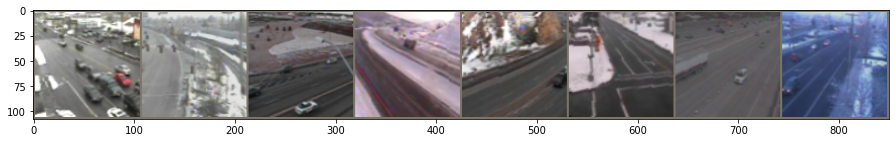

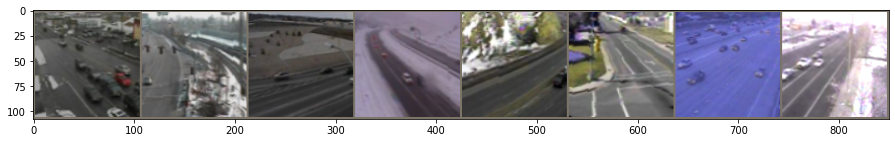

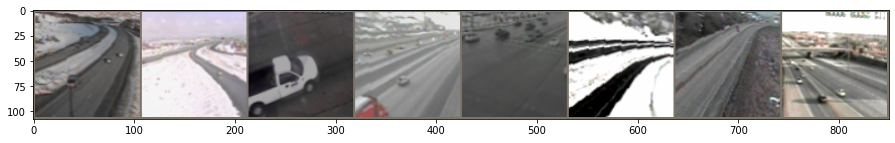

In [ ]:
def imshow(inp, title=None):
    #Imshow for Tensor
    inp = inp.cpu().detach().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)




dl_viz = {phase : torch.utils.data.DataLoader(ds[phase], shuffle = True, batch_size=8, num_workers=0)\
              for phase in ['train', 'val']}


imga, imgb, imgc, namea, nameb, namec  = next(iter(dl_viz['train']))

print(namea, nameb, namec)
#% Make a grid from batch
outa = utils.make_grid(imga)
outb = utils.make_grid(imgb)
outc = utils.make_grid(imgc)


plt.figure(figsize = (20,2))
imshow(outa)
plt.figure(figsize = (20,2))
imshow(outb)
plt.figure(figsize = (20,2))
imshow(outc)


In [ ]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.):
        super(TripletLoss, self).__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return (x1 - x2).pow(2).sum(1)
    
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

**Q4** Instancier un modèle ResNet50 (utiliser torchvision.models.resnet50) pré-entraîné sur le jeu imagenet. Modifier la dernière couche du réseau pour une tâche de réapprentissage (on travaillera dans un espace de sortie de dimension 10). 

In [ ]:
import torchvision

nclasses = 10
model = torchvision.models.resnet50(progress = True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, nclasses)

**Q5** Compléter la boucle d'apprentissage et vérifier son bon fonctionnement sur une époque.

In [ ]:
num_epochs = 1
bs = 16

# nb: num_workers = 0 lorsque les teneurs sont déjà sur GPU
dl = {phase : torch.utils.data.DataLoader(ds[phase], shuffle = True, batch_size=bs, num_workers=0)\
              for phase in ['train','val']}
import torch
import copy

model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 50, gamma = 0.2)
tripletloss = TripletLoss()

In [ ]:
#%%traing loop
#def learning(model):
since = time.time()
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
train_losses=[]
val_losses=[]
val_accs = []
min_loss = 100

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0
        # Iterate over data.
        
        for imga, imgb, imgc, _, _, _ in dl[phase]:

            if phase == 'train':
                optimizer.zero_grad()


            with torch.set_grad_enabled(phase == 'train'):
                outputa = model(imga)
                outputb = model(imgb)
                outputc = model(imgc)
                
                loss = tripletloss(outputa, outputb, outputc)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
           
          
            running_loss += loss.item() * imga.size(0)

            
            #del
            del imga, imgb, imgc
            del outputa, outputb, outputc
            del loss
            torch.cuda.empty_cache()
            
        epoch_loss = running_loss / len(ds[phase])


        print('{} Loss: {:.4f}'.format(
            phase, epoch_loss))

        if phase == 'train':
            train_losses.append(epoch_loss)
        elif phase == 'val':
            val_losses.append(epoch_loss)                     

        # deep copy the model
        if phase == 'val' and epoch_loss < min_loss:
            print('best loss')
            min_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())

    scheduler.step()  

**Q6** Charger les poids d'un modèle entraîné sur 50 époques ('data/reid_resnet50_60ep.pt'). 

In [ ]:
best_model_wts = torch.load('../data/reid_resnet50_60ep.pt')
model.load_state_dict(best_model_wts)

<All keys matched successfully>

**Q7** Présenter des cas de réussite et d'échec sur le jeu de test:
- deux images qui sont difficiles à attribuer (à l'oeil) à la même scène et pour lesquelles le modèle prédit deux points relativement proches dans l'espace latent.
- deux images faciles à attribuer à des scènes différentes et qui sont considérées comme issues de la même caméra par le modèle.
On s'appuiera sur les bouts de code suivants:

In [ ]:
ds['test'] = DS_singleton_flat(ds_tensor['test'], tr['test'])
dl['test'] = torch.utils.data.DataLoader(ds['test'], shuffle = False, batch_size=10, num_workers=0)

In [ ]:
# Calcul des sorties associées aux images du jeu de test :

from numpy.ma.core import ids
model.eval()
outputs = []
idxs = []
for img, idx in dl['test']:
            img = img.cuda()
            with torch.set_grad_enabled(False):
                output = model(img)
            outputs.append(output.cpu())
            del img, output
            torch.cuda.empty_cache()
            idxs += list(idx)
outputs = torch.cat(outputs, dim=0)
outputs = outputs.numpy()

In [ ]:
# Calcul de la matrice des distances euclidiennes entre
# les sorties associées aux images du jeu de test :

from scipy.spatial import distance_matrix
dist = distance_matrix(outputs, outputs)


**A)** Paires d'images associées à la même scène par le modèle (proches dans l'espace latent) malgré des différences d'aspects :

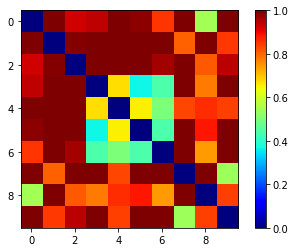

In [ ]:
# Recherche d'images associées à la même scène parmi les dix premières :
from matplotlib.pyplot import imshow
plt.figure(2)
t = 1.1
#Visualisation de la matrice des distances entre N et N+v:
N = 0
v = 10
imshow((dist)[N:N+v,N:N+v], vmin=0, vmax=1, cmap='jet')
plt.colorbar()

In [ ]:
# Visualisation d'une partie des images (ici, les images d'indices 860 à 870)
def imshow(inp, title=None):
    #Imshow for Tensor
    inp = inp.cpu().detach().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)



end_ds =  torch.utils.data.Subset(ds['test'], range(N,N+v))
dl_viz = torch.utils.data.DataLoader(end_ds, shuffle = False, batch_size=5, num_workers=0)\

it = iter(dl_viz)

tensor([0, 1, 2, 3, 4])
tensor([5, 6, 7, 8, 9])


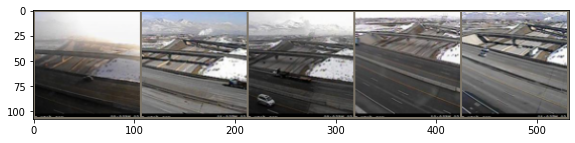

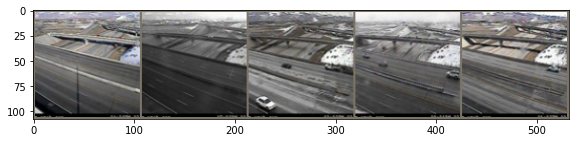

In [ ]:
imga, namea  = next(it)
imgz = imga.cpu()
print(namea)
#% Make a grid from batch
outa = utils.make_grid(imga)
plt.figure(figsize = (20,2))
imshow(outa)

imga, namea  = next(it)
imgz = imga.cpu()
print(namea)
#% Make a grid from batch
outa = utils.make_grid(imga)
plt.figure(figsize = (20,2))
imshow(outa)

Par exemple, la première image de la première rangée est jugée proche des deuxième ($d \approx 0.8$) et quatrième image ($d \approx 0.5$) de la seconde rangée, malgré l'apprente difficulté.

**B** Paires d'images associées à des scènes proches par le modèle (éloignées dans l'espace latent) malgré une différence évidente:

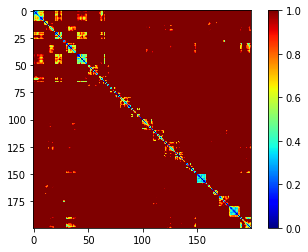

In [ ]:
# Recherche d'images associées à la même scène à tort :
# On regarde loin de la diagonale
from matplotlib.pyplot import imshow
plt.figure(2)
t = 1.1
#Visualisation de la matrice des distances entre N et N+v:
N = 410
v = 200
imshow((dist)[N:N+v,N:N+v], vmin=0, vmax=1., cmap='jet')
plt.colorbar()

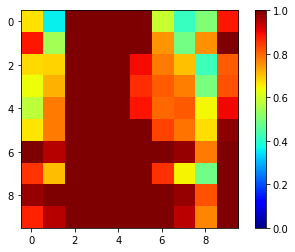

In [ ]:
# En particulier, on s'intéresse aux ressemblances entre les images 410 + 30:410 + 40 et les images 600 : 600 + 10 
# (d < 1  dans la matrice au dessus)
from matplotlib.pyplot import imshow
plt.figure(2)
t = 1.1
#Visualisation de la matrice des distances entre N et N+v:
N = 440
v = 30
imshow((dist)[440:450, 600:610], vmin=0, vmax=1., cmap='jet')
plt.colorbar()

In [ ]:
end_ds1 =  torch.utils.data.Subset(ds['test'], range(410 + 30, 410 + 40))
dl_viz1 = torch.utils.data.DataLoader(end_ds1, shuffle = False, batch_size=5, num_workers=0)\

it1 = iter(dl_viz1)

end_ds2 =  torch.utils.data.Subset(ds['test'], range(600, 600 + 10))
dl_viz2 = torch.utils.data.DataLoader(end_ds2, shuffle = False, batch_size=5, num_workers=0)\

it2 = iter(dl_viz2)


tensor([440, 441, 442, 443, 444])
tensor([445, 446, 447, 448, 449])
tensor([600, 601, 602, 603, 604])


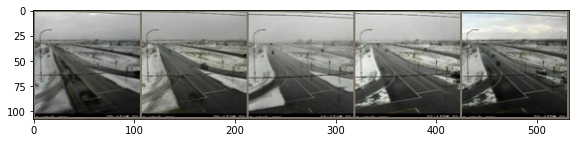

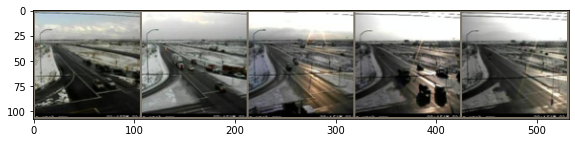

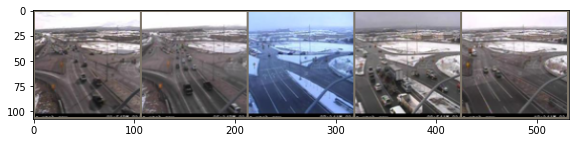

In [ ]:

def imshow(inp, title=None):
    #Imshow for Tensor
    inp = inp.cpu().detach().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

img1, name1  = next(it1)
print(name1)
#% Make a grid from batch
out1 = utils.make_grid(img1)
plt.figure(figsize = (20,2))
imshow(out1)

img1, name1  = next(it1)
print(name1)
#% Make a grid from batch
out1 = utils.make_grid(img1)
plt.figure(figsize = (20,2))
imshow(out1)

img2, name2  = next(it2)
print(name2)
#% Make a grid from batch
out2 = utils.make_grid(img2)
plt.figure(figsize = (20,2))
imshow(out2)


Les images 1 et 2 de la première ligne ainsi que les images 2,3,4 de la seconde sont toutes jugées proches des images de la dernière ligne.